In [12]:
import importlib
import utils
importlib.reload(utils)
import utils.data
importlib.reload(utils.data)
import utils.snf
importlib.reload(utils.snf)
import dataset
importlib.reload(dataset)
import networks.encoders_decoders
importlib.reload(networks.encoders_decoders)
import utils.train_val_test
importlib.reload(utils.train_val_test)

print("libraries reloaded!")

from dataset import MoGCN_Dataset, Omics_Dataset

libraries reloaded!


In [5]:
from utils.data import read_MoGCN_data
import os
import torch

data_path = "data/train"
omics_file_names = ["fpkm_data.csv", "gistic_data.csv", "rppa_data.csv"]
gt_file_name = "sample_classes.csv"

train_omics_data, train_gt_data, samples_list, gt_classes = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

# To Tensor
omics_data = [
    torch.tensor(omics.loc[:, omics.columns != "Sample"].values, dtype=torch.float)
    for omics in train_omics_data
]

x_omics = torch.cat((omics_data[0], omics_data[1], omics_data[2]), dim=1)

y_classes = torch.tensor(gt_classes, dtype=torch.long)

input_dims = [omics.shape[1] - 1 for omics in train_omics_data]

In [ ]:
from torch_geometric.utils import to_edge_index
import torch
from utils.snf import run_snf

fused = run_snf(train_omics_data)

In [14]:


m_A = torch.load("./checkpoints/H_Low_VAE_omics_A.pkl")
m_B = torch.load("./checkpoints/H_Low_VAE_omics_B.pkl")
m_C = torch.load("./checkpoints/H_Low_VAE_omics_C.pkl")

models = [m_A, m_B, m_C]
latent_spaces = []
for i in range(len(models)):
    print(models[i].name)
    train_MoGCN = Omics_Dataset(train_omics_data[i], train_gt_data)
    latent_spaces.append(models[i].get_latent_space(train_MoGCN.omics_data))

H_Low_VAE_omics_A


RuntimeError: mat1 and mat2 shapes cannot be multiplied (434x19580 and 19446x256)

In [ ]:


affinity_nets = snf.make_affinity(
    [
        omics_data[0].iloc[:, 1:].values.astype(np.float64),
        omics_data[1].iloc[:, 1:].values.astype(np.float64),
        omics_data[2].iloc[:, 1:].values.astype(np.float64),
    ],
    metric=metric,
    K=k,
    mu=mu,
)

fused_net = snf.snf(affinity_nets, K=k)

In [ ]:
import numpy as np

fused_snf = fused.copy()
threshold = 0.005
fused_snf[fused_snf >= threshold] = 1
fused_snf[fused_snf < threshold] = 0

np.fill_diagonal(fused_snf, 0)

# edge_index = to_edge_index(torch.tensor(adj_matrix, dtype=torch.float).nonzero().t().contiguous())
edge_index = to_edge_index((torch.tensor(fused_snf, dtype=torch.long).to_sparse()))[0]

In [14]:
edge_index.shape

torch.Size([2, 1416])

In [2]:
import numpy as np
from torch_geometric.utils import to_edge_index
import torch

n_samples = train_omics_data[0].shape[0]
adj = np.ones((n_samples, n_samples))
np.fill_diagonal(adj, 0)

edge_index = to_edge_index((torch.tensor(adj, dtype=torch.long).to_sparse()))[0]

In [3]:
edge_index.shape

torch.Size([2, 187922])

In [15]:
from networks.encoders_decoders import MoGCN_AE
from utils.train_val_test import train_loop, setup_seed
from dataset import MoGCN_Dataset
from torch import optim, nn
from torch.utils.data import DataLoader

setup_seed()
DEVICE = torch.device("cuda")

# Hyperparameters
lr = 0.001
latent_space_dim = 300
batch_size = 32

# Dataset
train_MoGCN = MoGCN_Dataset(train_omics_data, train_gt_data)
train_loader = DataLoader(train_MoGCN, batch_size=batch_size, shuffle=True)

In [ ]:
model_ae = MoGCN_AE(input_dims, latent_dim=latent_space_dim)
optimizer = optim.Adam(model_ae.parameters(), lr=lr)
model_ae.to(DEVICE)

train_loop(model_ae, optimizer,train_loader,"./data")

In [3]:
model_ae = torch.load("./data/MoGCN_AE.pkl")

node_features = model_ae.get_latent_space(train_MoGCN)
node_features = torch.tensor(node_features, dtype=torch.float)
node_features.size()

torch.Size([434, 300])

In [5]:
from torch_geometric.utils import to_edge_index
import torch
import pandas as pd
from utils.snf import run_snf

fused = run_snf(pd.DataFrame(node_features))

import numpy as np

fused_snf = fused.copy()
threshold = 0.005
fused_snf[fused_snf >= threshold] = 1
fused_snf[fused_snf < threshold] = 0

np.fill_diagonal(fused_snf, 0)

# edge_index = to_edge_index(torch.tensor(adj_matrix, dtype=torch.float).nonzero().t().contiguous())
edge_index = to_edge_index((torch.tensor(fused_snf, dtype=torch.long).to_sparse()))[0]

IndexingError: Too many indexers

In [132]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, input_dim, latent_dim=300, n_classes=4):
        super().__init__()
        self.gcn = GCNConv(input_dim, latent_dim)
        self.out = Linear(latent_dim, n_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).sigmoid()
        z = self.out(h)
        return h, z


model_gcn = GCN(input_dims[0]+input_dims[1]+input_dims[2])
print(model_gcn)

GCN(
  (gcn): GCNConv(39076, 300)
  (out): Linear(in_features=300, out_features=4, bias=True)
)


In [20]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)
    

model_gat = GAT(node_features.shape[1], 100, 4)
print(model_gat)

GAT(
  (gat1): GATv2Conv(300, 100, heads=8)
  (gat2): GATv2Conv(800, 4, heads=1)
)


In [9]:
import pandas as pd
df = pd.DataFrame(gt_classes, columns=["gt_classes"])
class_weights = len(df['gt_classes'])/df['gt_classes'].value_counts()
class_weights = torch.tensor(class_weights.to_list(),dtype=torch.float)

In [10]:
class_weights

tensor([2.0569, 4.5684, 5.2289, 9.6444])

In [21]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

Epoch  10 | Loss: 1.38 | Acc: 35.94%


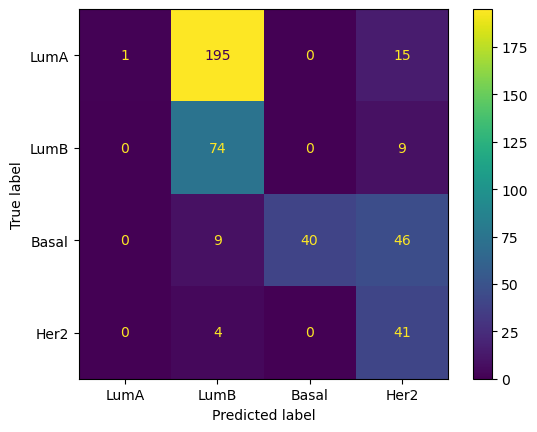

Epoch  20 | Loss: 0.65 | Acc: 67.74%


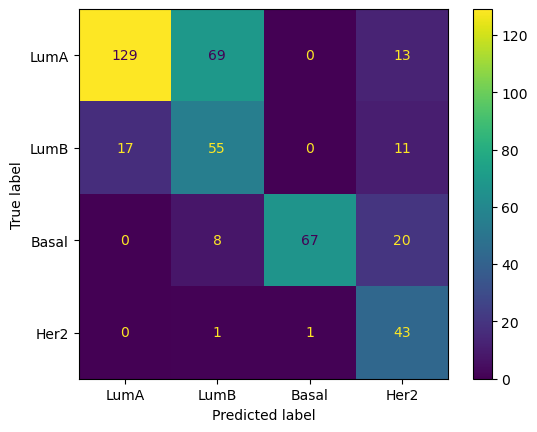

Epoch  30 | Loss: 0.61 | Acc: 77.88%


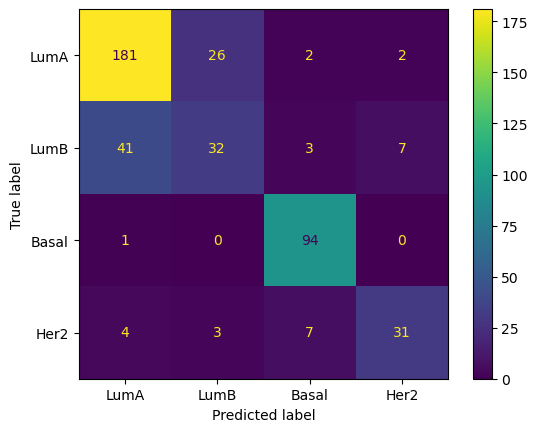

Epoch  40 | Loss: 0.51 | Acc: 78.11%


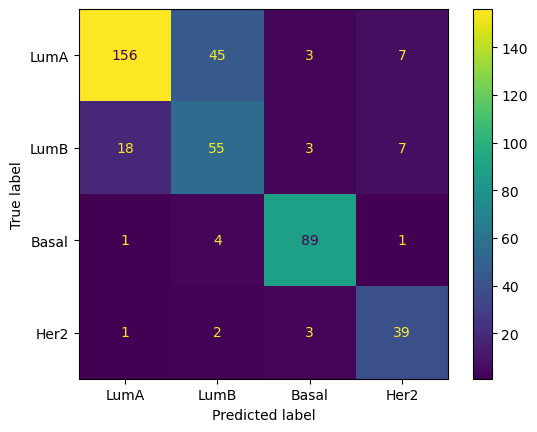

Epoch  50 | Loss: 0.64 | Acc: 78.34%


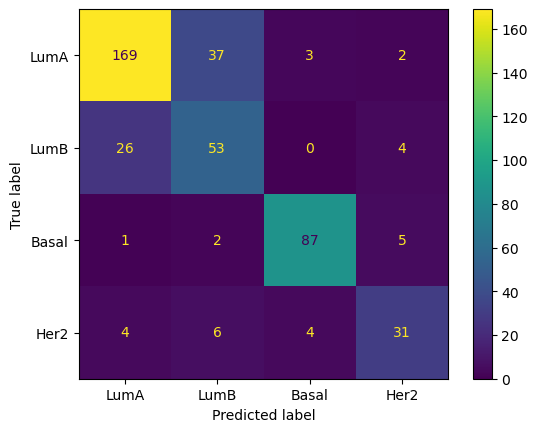

In [25]:
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.005,
                                          weight_decay=5e-4)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(50):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model_gat(node_features, edge_index)

    # Calculate loss function
    loss = criterion(z, y_classes)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), y_classes)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')
        cm = confusion_matrix(y_classes, z.argmax(dim=1), normalize=True)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LumA", "LumB", "Basal", "Her2"])
        cm_display.plot()
        plt.show()